<b><font size="5">Using Flow Duration Curves to Determine Basin Characteristics and Estimate Flow</font></b>

This notebook uses the Scientific Python (scipy) stack tools to generate flow duration curves from current USGS NWIS data.

Using recipes from this notebook, you can make:
* USGS Station Summaries
* Flow duration curves
* Iterative import and compilation of USGS station information and data
* boxplots using pandas
* iterative charts (one monthly summary boxplot per station)
* Gantt charts of USGS stations

## Background

Import necessary packages. <a href=http://ulmo.readthedocs.org/en/latest/>`ulmo`</a> is not a standard package and will have to be loaded into your local python repository for some of these functions to work. Use the following command in your cmd prompt to install `ulmo`.
```cmd
pip install ulmo
```
You might also be missing the <a href=http://pandas.pydata.org/>`pandas`</a> and <a href=http://www.scipy.org/>`scipy`</a> packages, which is a shame, because `pandas` is awesome.
```cmd
pip install pandas
pip install scipy
```
Check out this for some great `pandas` applications:
http://earthpy.org/time_series_analysis_with_pandas_part_2.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
import ulmo
from pandas.stats.api import ols
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pyplot import cm 
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
import logging
logging.basicConfig()
logger = logging.getLogger('ulmo.usgs.nwis.core')
logger.setLevel(logging.WARNING)

`rpy2` allows one to run `R` files within IPython Notebook. You may need to configure the environment variable settings for this to work properly. If you get errors, use the Google. 

In [3]:
import rpy2

Set a directory to store output figures:

In [4]:
rootname = 'U:\\GWP\\Groundwater\\UMSS_Manti\\Data\\Hydrology\\plots\\'
dataroot = 'U:\\GWP\\Groundwater\\UMSS_Manti\\Data\\Hydrology\\'

#Functions

The function `importusgssite` uses the <a href=http://ulmo.readthedocs.org/en/latest/>`ulmo`</a> package to retrieve U.S. Geological Survey surface water site data from the <a href=http://waterdata.usgs.gov/nwis>National Water Information System (NWIS) website</a>.  The function also puts the data from the website into a usable format. `getusgssiteinfo` gets site information from NWIS, which includes site name, watershed size, and coordinates.

In [5]:
def importusgssite(siteno):
    sitename = {}
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    sitename = pd.DataFrame(sitename['00060:00003']['values'])
    sitename['dates'] = pd.to_datetime(pd.Series(sitename['datetime']))
    sitename.set_index(['dates'],inplace=True)
    sitename[siteno] = sitename['value'].astype(float)
    sitename[str(siteno)+'qual'] = sitename['qualifiers']
    sitename = sitename.drop(['datetime','qualifiers','value'],axis=1)
    sitename = sitename.replace('-999999',np.NAN)
    sitename = sitename.dropna()
    #sitename['mon']=sitename.index.month
    return sitename

In [6]:
def getusgssiteinfo(siteno):
    siteinfo = ulmo.usgs.nwis.get_site_data(siteno, service="daily", period="all")
    siteinfo = pd.DataFrame(siteinfo['00060:00003']['site'])
    siteinfo['latitude'] = siteinfo.loc['latitude','location']
    siteinfo['longitude'] = siteinfo.loc['longitude','location']
    siteinfo['latitude'] = siteinfo['latitude'].astype(float)
    siteinfo['longitude'] = siteinfo['longitude'].astype(float)
    siteinfo = siteinfo.drop(['default_tz','dst_tz','srs','uses_dst','longitude'],axis=0)
    siteinfo = siteinfo.drop(['agency','timezone_info','location','state_code','network'],axis=1)
    return siteinfo

`fdc` generates a flow duration curve for hydrologic data. A flow duration curve is a <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#PPF>percent point function (ppf)</a>, displaying discharge as a function of probability of that discharge occuring. The ppf is the inverse of the better known <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#CDF>cumulative distribution function (cdf)</a>. See <a href=http://pubs.usgs.gov/wsp/1542a/report.pdf>this USGS publication</a> for more information.

In [7]:
def fdc(df,site,begyear,endyear):
    '''
    Generate flow duration curve for hydrologic time series data
    
    df = pandas dataframe containing data
    site = column within dataframe that contains the flow values
    begyear = start year for analysis
    endyear = end year for analysis
    '''
        
    data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]
    data = data[site].dropna().values
    data = np.sort(data)
    ranks = sp.rankdata(data, method='average')
    ranks = ranks[::-1]
    prob = [100*(ranks[i]/(len(data)+1)) for i in range(len(data)) ]
    plt.figure()
    plt.scatter(prob,data,label=site)
    plt.yscale('log')
    plt.grid(which = 'both')
    plt.xlabel('% of time that indicated discharge was exceeded or equaled')
    plt.ylabel('discharge (cfs)')
    plt.xticks(range(0,100,5))
    plt.title('Flow duration curve for ' + site)

In [8]:
def fdc_simple(df, site, begyear=1900, endyear=2015, normalizer=1):
    '''
    Generate flow duration curve for hydrologic time series data
    
    PARAMETERS:
        df = pandas dataframe of interest; must have a date or date-time as the index
        site = pandas column containing discharge data; must be within df
        begyear = beginning year of analysis; defaults to 1900
        endyear = end year of analysis; defaults to 2015
        normalizer = value to use to normalize discharge; defaults to 1 (no normalization)
    
    RETURNS:
        matplotlib plot displaying the flow duration curve of the data
        
    REQUIRES:
        numpy as np
        pandas as pd
        matplotlib.pyplot as plt
        scipy.stats as sp
    '''
    # limit dataframe to only the site
    df = df[[site]]
    
    # filter dataframe to only include dates of interest
    data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]

    # remove na values from dataframe
    data = data.dropna()

    # take average of each day of year (from 1 to 366) over the selected period of record
    data['doy']=data.index.dayofyear
    dailyavg = data[site].groupby(data['doy']).mean()
        
    data = np.sort(dailyavg)

    ## uncomment the following to use normalized discharge instead of discharge
    #mean = np.mean(data)
    #std = np.std(data)
    #data = [(data[i]-np.mean(data))/np.std(data) for i in range(len(data))]
    data = [(data[i])/normalizer for i in range(len(data))]
    
    # ranks data from smallest to largest
    ranks = sp.rankdata(data, method='average')

    # reverses rank order
    ranks = ranks[::-1]
    
    # calculate probability of each rank
    prob = [(ranks[i]/(len(data)+1)) for i in range(len(data)) ]
    
    # plot data via matplotlib
    plt.plot(prob,data,label=site+' '+str(begyear)+'-'+str(endyear))

The `fdcmatch` uses Python's optimization capabilities to fit natural logarithim and exponential functions the flow duration curves.

In [9]:
def fdcmatch(df, site, begyear=1900, endyear=2015, normalizer=1, fun=1):
    '''
    * This function creates a flow duration curve (or its inverse) and then matches a natural logrithmic function (or its inverse - exp) 
    to the flow duration curve
    * The flow duration curve will be framed for averaged daily data for the duration of one year (366 days)
    
    PARAMETERS:
        df = pandas dataframe of interest; must have a date or date-time as the index
        site = pandas column containing discharge data; must be within df
        begyear = beginning year of analysis; defaults to 1900
        endyear = end year of analysis; defaults to 2015
        normalizer = value to use to normalize discharge; defaults to 1 (no normalization)
        fun = 1 for probability as a function of discharge; 0 for discharge as a function of probability; default=1 
            * 1 will choose:
                prob = a*ln(discharge*b+c)+d
            * 0 will choose:
                discharge = a*exp(prob*b+c)+d
    RETURNS:
        para, parb, parc, pard, r_squared_value, stderr
    
        par = modifying variables for functions = a,b,c,d
        r_squared_value = r squared value for model
        stderr = standard error of the estimate
    
    REQUIREMENTS:
        pandas, scipy, numpy
    '''
    df = df[[site]]
    
    # filter dataframe to only include dates of interest
    data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]

    # remove na values from dataframe
    data = data.dropna()

    # take average of each day of year (from 1 to 366) over the selected period of record
    data['doy']=data.index.dayofyear
    dailyavg = data[site].groupby(data['doy']).mean()
        
    data = np.sort(dailyavg)

    ## uncomment the following to use normalized discharge instead of discharge
    #mean = np.mean(data)
    #std = np.std(data)
    #data = [(data[i]-np.mean(data))/np.std(data) for i in range(len(data))]
    data = [(data[i])/normalizer for i in range(len(data))]
    
    # ranks data from smallest to largest
    ranks = sp.rankdata(data, method='average')

    # reverses rank order
    ranks = ranks[::-1]
    
    # calculate probability of each rank
    prob = [(ranks[i]/(len(data)+1)) for i in range(len(data)) ]
 
    # choose which function to use
    try:
        if fun==1:
            # function to determine probability as a function of discharge
            def func(x,a,b,c,d):
                return a*np.log(x*b+c)+d

            # matches func to data
            par, cov = op.curve_fit(func, data, prob)

            # checks fit of curve match
            slope, interecept, r_value, p_value, stderr = \
            sp.linregress(prob, [par[0]*np.log(data[i]*par[1]+par[2])+par[3] for i in range(len(data))])
        else:
            # function to determine discharge as a function of probability
            def func(x,a,b,c,d):
                return a*np.exp(x*b+c)+d

            # matches func to data
            par, cov = op.curve_fit(func, prob, data)

            # checks fit of curve match
            slope, interecept, r_value, p_value, stderr = \
            sp.linregress(data,[par[0]*np.exp(prob[i]*par[1]+par[2])+par[3] for i in range(len(prob))])

        # return parameters (a,b,c,d), r-squared of model fit, and standard error of model fit 
        return par[0], par[1], par[2], par[3], round(r_value**2,2), round(stderr,5)
    except (RuntimeError,TypeError):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

The list `sites` designates the USGS surface sites you are interested in analyzing.

In [10]:
sites = ['09309500','09309600','09309800','09310000','09310500','09310550','09310575','09310600',
 '09310700','09311500','09311700','09312600','09312700','09317000','09317500','09317919',
 '09317920','09317997','09318000','09318500','09319000','09319001','09320000','09320500',
 '09321000','09321500','09322000','09322500','09323000','09323500','09324000','09324200',
 '09324500','09325000','09325100','09325500','09326000','09326500','09327500','09327550',
 '09330500','09331850','09331900','09331950','09332100','10148400','10148500','10205030',
 '10206000','10206001','10208000','10208500','10210000','10210500','10211000','10215700',
 '10215900','10216210','10216400','10217000']
sitelab = ['Q'+site for site in sites]

## Import Stream Gage Discharge Data

Now we can run through all of the sites and import thier data!

In [11]:
#d = {site: importusgssite(site) for site in sites}
d = {}
for site in sites:
    d[site] = importusgssite(site);

Lets merge all of the site data together in one dataframe, so that all of the daily data are aligned and together in one place.  We will call that one place `USGS_Site_Data`! While we are at it, we will add month, year, and day of year columns to make summarizing the data easier.

In [12]:
f = {}
f[sites[0]] = d[sites[0]]
for i in range(len(sites)-1):
    f[sites[i+1]] = pd.merge(d[sites[i+1]], f[sites[i]], left_index=True, right_index=True, how='outer')

In [13]:
USGS_Site_Data = f[sites[-1]]
USGS_Site_Data['mon']=USGS_Site_Data.index.month
USGS_Site_Data['yr']=USGS_Site_Data.index.year
USGS_Site_Data['dy']=USGS_Site_Data.index.dayofyear

In [14]:
USGS_Site_Data.to_csv(dataroot+'USGS_Site_Data.csv')

## Import Stream Gage Site Information

Now we should import the information on each site.

In [15]:
z = {}
for site in sites:
    z[site] = getusgssiteinfo(site);

Like we did with the data, we will combine all of the site information together in one table, so that it is easy to read.

In [16]:
USGS_Site_Info = pd.concat(z)
USGS_Site_Info = USGS_Site_Info.reset_index()
USGS_Site_Info = USGS_Site_Info.drop(['level_1'],axis=1)
USGS_Site_Info = USGS_Site_Info.set_index(['level_0'])
USGS_Site_Info = USGS_Site_Info.drop(['code'],axis=1)

Lets extract the measurement start and end dates from the station data, as well as some basic summary statistics.  We can tack this information onto the site information table we created above.

In [17]:
q = {}
m = {}
for site in sites:
    q[site] = USGS_Site_Data[site].first_valid_index()
    m[site] = USGS_Site_Data[site].last_valid_index()

USGS_start_date = pd.DataFrame(data=q, index=[0])
USGS_finish_date = pd.DataFrame(data=m, index=[0])
USGS_start_date = USGS_start_date.transpose()
USGS_start_date['start_date'] = USGS_start_date[0]
USGS_start_date = USGS_start_date.drop([0],axis=1)
USGS_finish_date = USGS_finish_date.transpose()
USGS_finish_date['fin_date'] = USGS_finish_date[0]
USGS_finish_date = USGS_finish_date.drop([0],axis=1)
USGS_start_fin = pd.merge(USGS_finish_date,USGS_start_date, left_index=True, right_index=True, how='outer' )

In [18]:
USGS_Site_Info = pd.merge(USGS_start_fin,USGS_Site_Info, left_index=True, right_index=True, how='outer' )

In [19]:
USGS_sum_stats = USGS_Site_Data[sites].describe()
USGS_sum_stats = USGS_sum_stats.transpose()

In [20]:
USGS_Site_Info = pd.merge(USGS_sum_stats,USGS_Site_Info, left_index=True, right_index=True, how='outer' )

The next line allows us to save the site information table to a clipboard, which can be pasted into a spreadsheet, for those who like visualizing information in Excel and similar products.

In [21]:
USGS_Site_Info.to_clipboard()

We can use the site information to generate a <a href=https://en.wikipedia.org/wiki/Gantt_chart>Gantt chart</a>, showing the duration that each station measured.

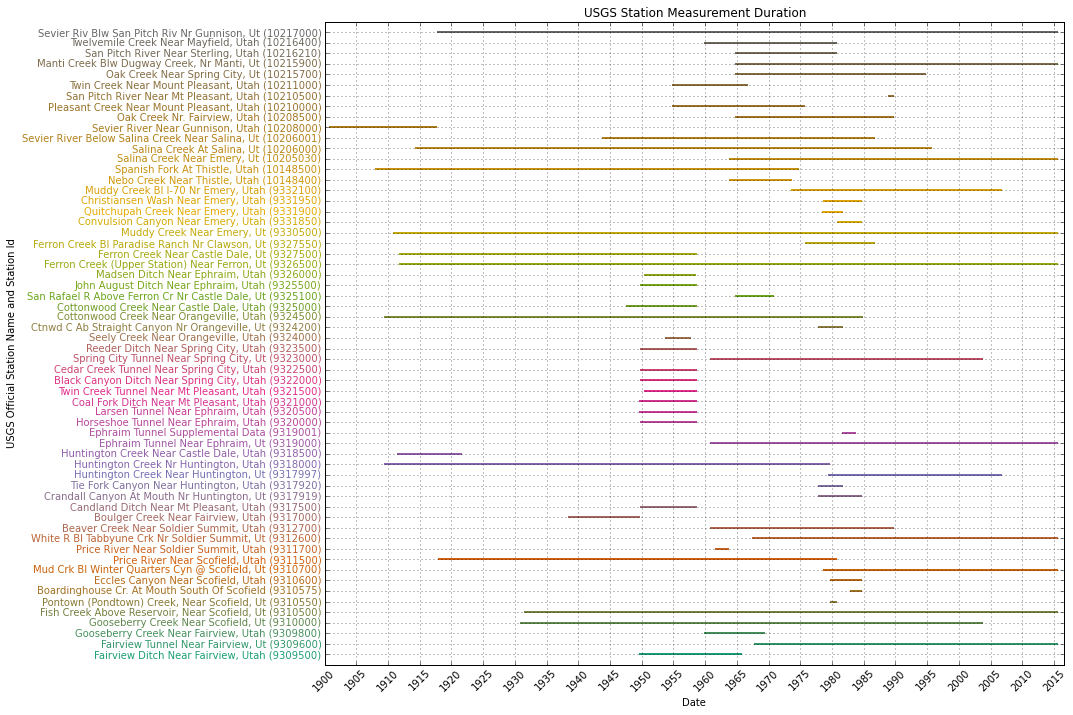

In [23]:
# designate variables
x2 = USGS_Site_Info['fin_date'].astype(datetime).values
x1 = USGS_Site_Info['start_date'].astype(datetime).values
y = USGS_Site_Info.index.astype(np.int)
names = USGS_Site_Info['name'].values

labs, tickloc, col = [], [], []

# create color iterator for multi-color lines in gantt chart
color=iter(cm.Dark2(np.linspace(0,1,len(y))))

plt.figure(figsize=[8,10])
fig, ax = plt.subplots()

# generate a line and line properties for each station
for i in range(len(y)):
    c=next(color)
    
    plt.hlines(i+1, x1[i], x2[i], label=y[i], color=c, linewidth=2)
    labs.append(names[i].title()+" ("+str(y[i])+")")
    tickloc.append(i+1)
    col.append(c)
plt.ylim(0,len(y)+1)
plt.yticks(tickloc, labs)

# create custom x labels
plt.xticks(np.arange(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25),timedelta(days=365.25*5)),rotation=45)
plt.xlim(datetime(np.min(x1).year,1,1),np.max(x2)+timedelta(days=365.25))
plt.xlabel('Date')
plt.ylabel('USGS Official Station Name and Station Id')
plt.grid()
plt.title('USGS Station Measurement Duration')
# color y labels to match lines
gytl = plt.gca().get_yticklabels()
for i in range(len(gytl)):
    gytl[i].set_color(col[i])
plt.tight_layout()

plt.savefig(rootname+'gantt.pdf')

## Visualizing Data

## Exporting Figures

The following script will generate a series of box and whisker plots and save them in a pdf. It makes a box plot for each station, breaking the data into monthly intervals.  Make sure to change the directory name in the script so it ends up in a recognizable place on your computer.  

In [24]:
# create dictionary of integers and their month equivalent
months = {'1':'Jan.', '2':'Feb.', '3':'Mar.', '4':'Apr.', '5':'May', '6':'Jun.', 
         '7':'Jul.', '8':'Aug.', '9':'Sep.', '10':'Oct.', '11':'Nov.', '12':'Dec.', 'Total':'Total'}
# create empty dictionary to hold pandas Dataframes
j = {}


with PdfPages(rootname + 'station_boxplots.pdf') as pdfs:
    ymax = 10000
    ymin = 0.01
    for i in range(len(sites)):
        # make a dataframe containing summary statistics and store it in the j dictionary
        j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg([np.min, np.mean, np.median, np.max, np.std, np.size]).reset_index()
        # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
        labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['size'][b])) + ")" for b in range(len(j[sites[i]]))]
        # designate the location of each custom label
        tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]
        
        plt.figure()
        USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
        plt.title(USGS_Site_Info.ix[sites[i],'name'].title() + ' (' + sites[i] + ')')
        plt.suptitle('')
        plt.yscale('log')
        plt.ylabel('Discharge (cfs)')
        plt.ylim((ymin,ymax))
        plt.xlabel('Month')
        # here is where your lists for the custom label come into play
        plt.xticks(tickloc, labs)
        
        pdfs.savefig()

        plt.close()
    # Save metadata of the pdf so you can find it later
    d = pdfs.infodict()
    d['Title'] = 'Monthly Station USGS Boxplots UMSS'
    d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
    d['Subject'] = 'Boxplots of several USGS Surface Stations'
    d['Keywords'] = 'USGS Surface NWIS Boxplot'
    d['CreationDate'] = datetime.today()
    d['ModDate'] = datetime.today()

C:\Python27\ArcGIS10.3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Let's plot a few of the boxplots so you can see what they look like.

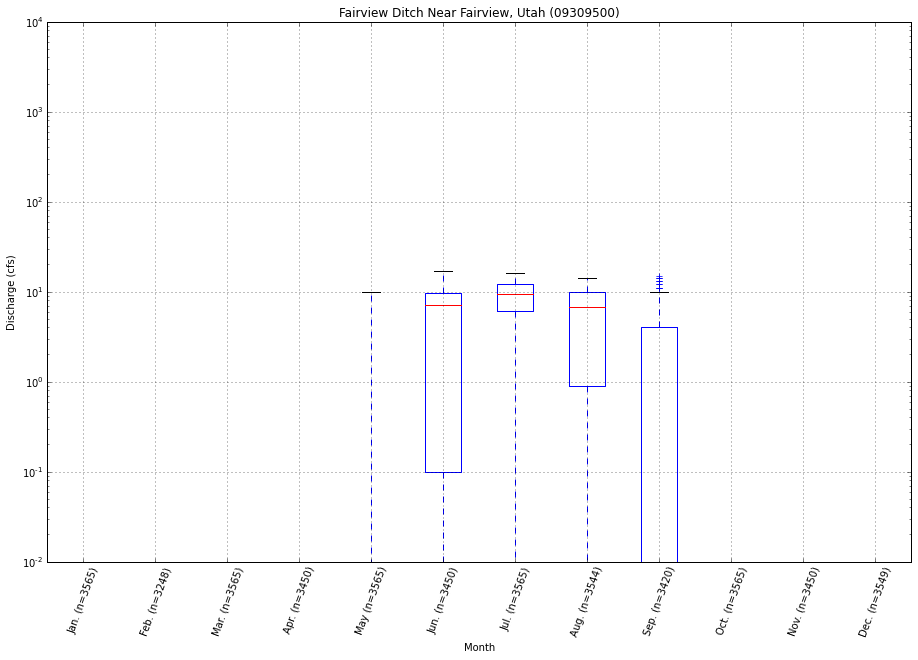

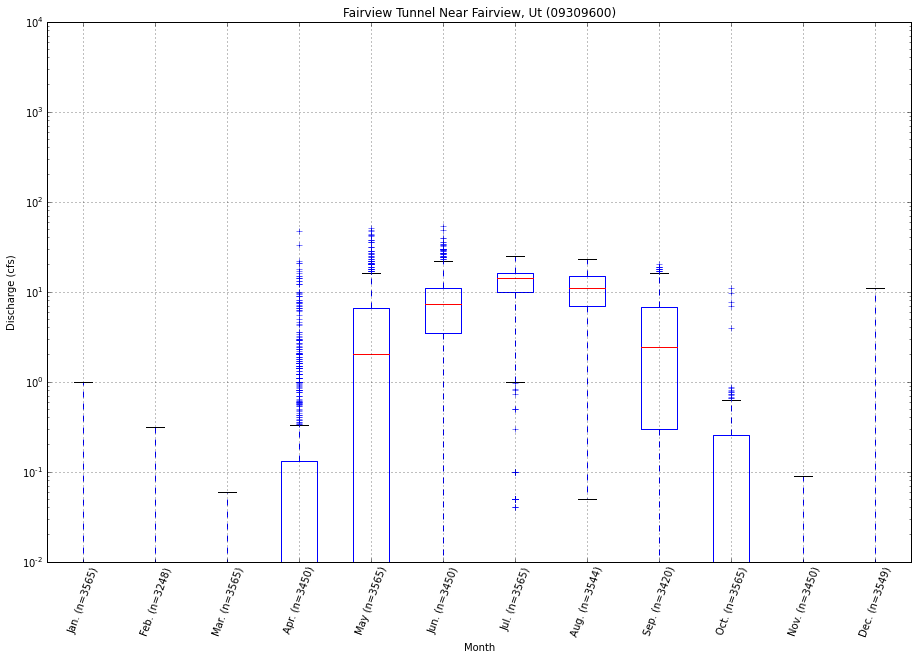

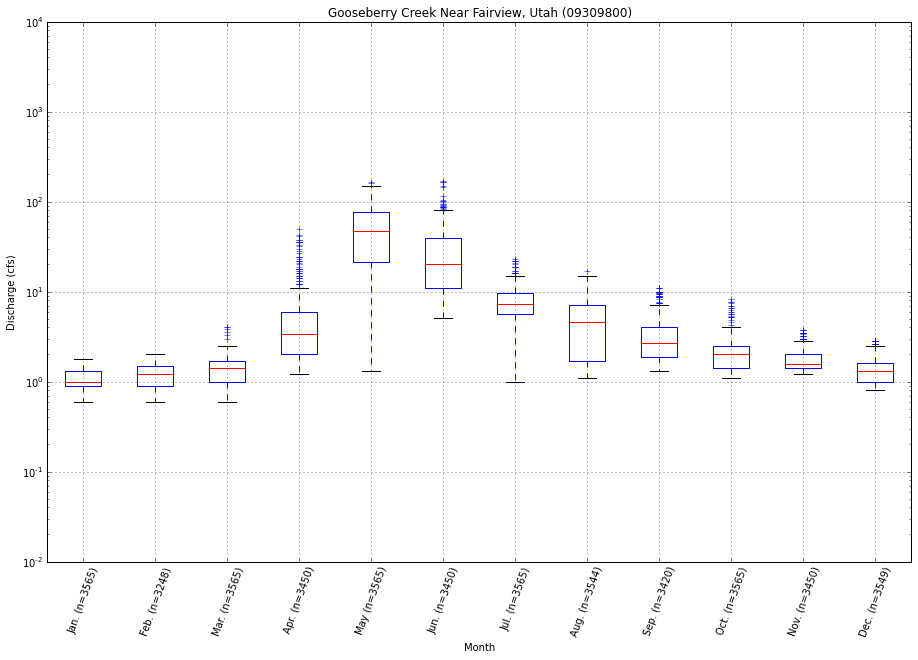

In [25]:
for i in range(3):
    j[sites[i]] = USGS_Site_Data.groupby('mon')[sites[i]].agg([np.min, np.mean, np.median, np.max, np.std, np.size]).reset_index()
    # make a list of the custom lables you will use for your boxplot; this one will show the number of samples used to make the plot
    labs = [months[(str(j[sites[i]]['mon'][b]))] + " (n=" + str(int(j[sites[i]]['size'][b])) + ")" for b in range(len(j[sites[i]]))]
    # designate the location of each custom label
    tickloc = [b+1 for b in range(len(j[sites[i]]['mon']))]

    plt.figure()
    USGS_Site_Data.boxplot(column=sites[i],by='mon', rot=70)
    plt.title(USGS_Site_Info.ix[sites[i],'name'].title() + ' (' + sites[i] + ')')
    plt.suptitle('')
    plt.yscale('log')
    plt.ylabel('Discharge (cfs)')
    plt.ylim((ymin,ymax))
    plt.xlabel('Month')
    # here is where your lists for the custom label come into play
    plt.xticks(tickloc, labs)
    plt.show()
    plt.close()

This script will generate boxplots showing all of the station data.

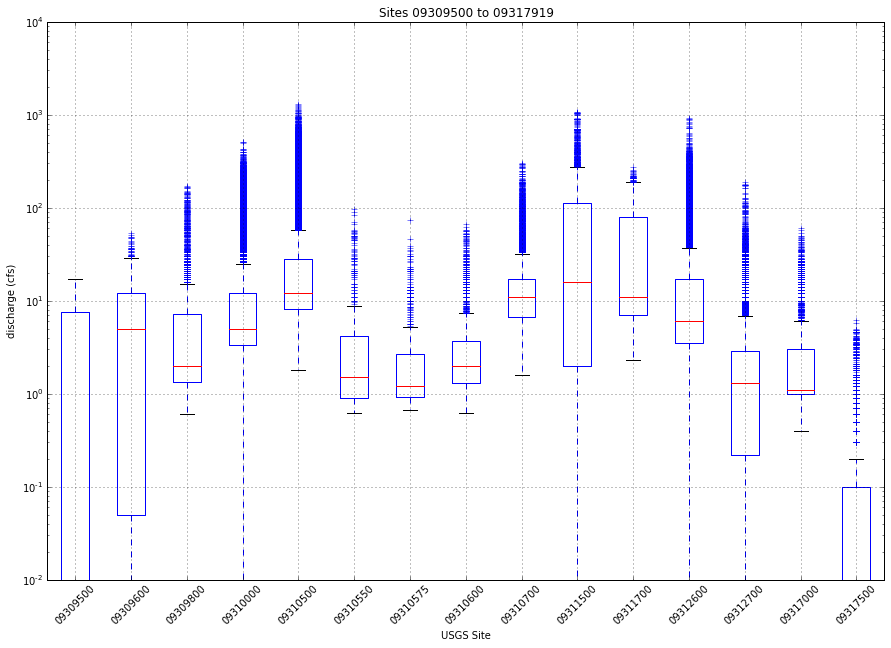

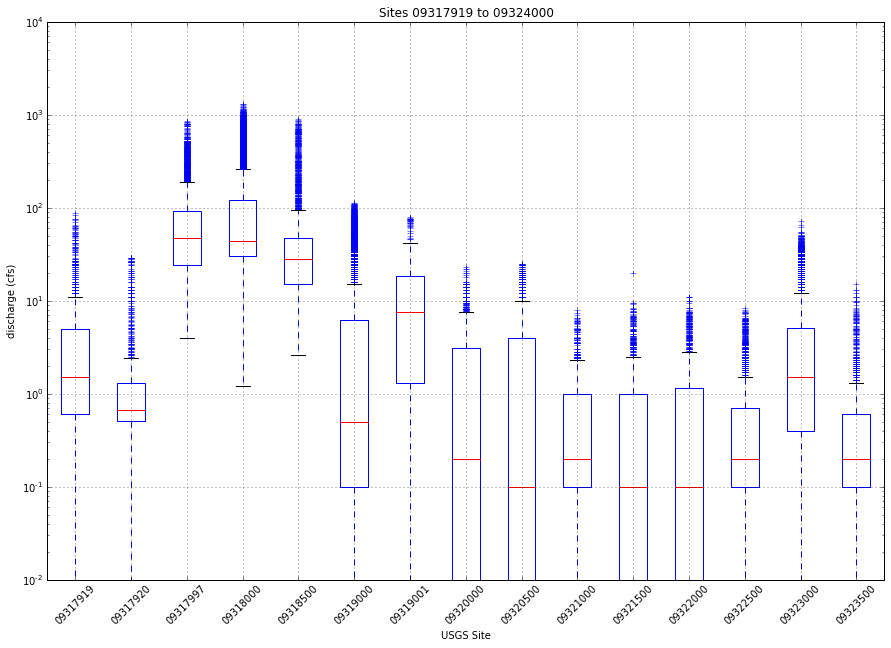

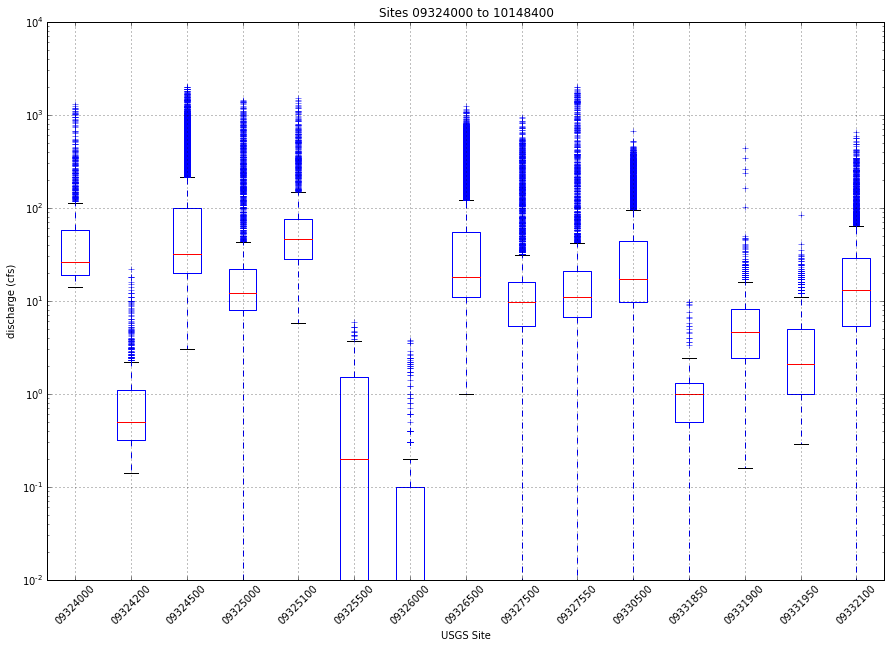

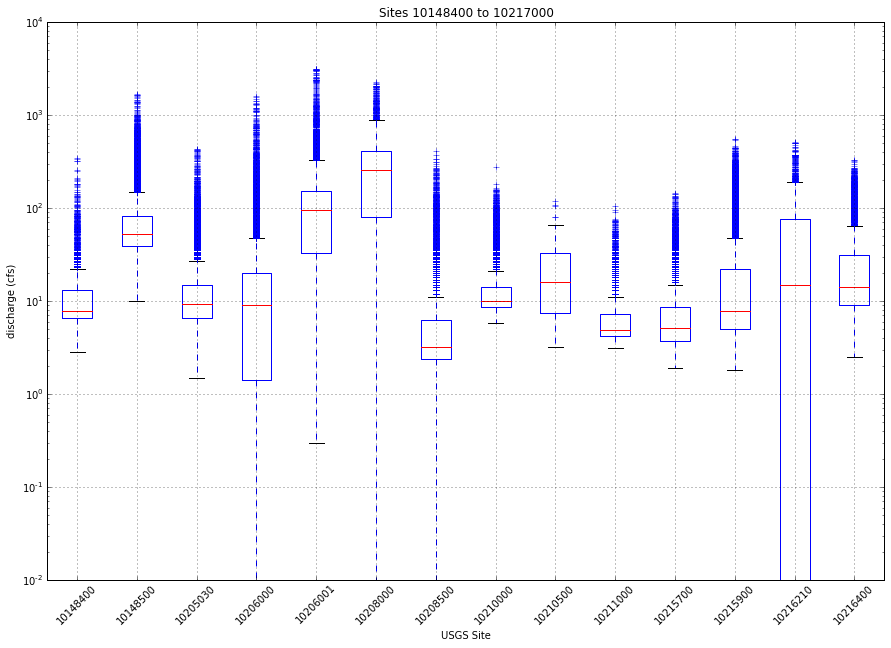

In [26]:
# This script summarizes discharge for all sites and limits the number of box plots on one graph to the n variable
j=0
with PdfPages(rootname + 'sum_boxplots.pdf') as pdf:
    while j < len(sites):
        ymax = 10000
        ymin = 0.01
        n=15
        # if statement allows for uneven number of sites on last page
        if j+n >= len(sites):
            plt.figure()
            USGS_Site_Data[sites[j:-1]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[-1] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        else:
            plt.figure()
            USGS_Site_Data[sites[j:j+n]].plot(kind='box')
            plt.title('Sites '+sites[j]+' to '+sites[j+n] )
            plt.yscale('log')
            plt.xlabel('USGS Site')
            plt.xticks(rotation=45)
            plt.ylabel('discharge (cfs)')
            plt.ylim((ymin,ymax))
            pdf.savefig()
            plt.show()
            plt.close()
            j = j+n
        # Save metadata of the pdf so you can find it later
        d = pdf.infodict()
        d['Title'] = 'Summary USGS Boxplots UMSS'
        d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
        d['Subject'] = 'Boxplots of several USGS Surface Stations'
        d['Keywords'] = 'USGS Surface NWIS Boxplot'
        d['CreationDate'] = datetime.today()
        d['ModDate'] = datetime.today()

This script will iteratively produce Flow Duration Curves for each of the stations. A flow duration curve is a <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#PPF>percent point function (ppf)</a>, displaying discharge as a function of probability of that discharge occuring. The ppf is the inverse of the better known <a href=http://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm#CDF>cumulative distribution function (cdf)</a>. See <a href=http://pubs.usgs.gov/wsp/1542a/report.pdf>this USGS publication</a> for more information.

In [27]:
with PdfPages(rootname+'station_fdc.pdf') as pdf:
    ymax = 10000
    ymin = 0.01
    for i in range(len(sites)):
        plt.figure()
        fdc_simple(USGS_Site_Data,sites[i],1900,2015)
        fdc_simple(USGS_Site_Data,sites[i],1900,1970)
        fdc_simple(USGS_Site_Data,sites[i],1970,2015)
        plt.ylim(0.01,10000)
        plt.xlim(-.05,1.05)
        plt.grid(which = 'both')
        plt.legend()
        plt.xlabel('probability that discharge was exceeded or equaled')
        plt.title('Flow duration curve for ' + str(USGS_Site_Info['name'][i]).title() + ' ('+ sites[i] +')'+'\n'+
                  'Record: ' + str(USGS_Site_Info['start_date'][i])[0:10] + ' to ' + str(USGS_Site_Info['fin_date'][i])[0:10])
        plt.yscale('log')
        plt.ylabel('discharge (cfs)')
        plt.xticks(np.arange(0,1.05,0.05))
        pdf.savefig()
        plt.close()
    # Save metadata of the pdf so you can find it later
    d = pdf.infodict()
    d['Title'] = 'Flow Duration Curves USGS'
    d['Author'] = u'Paul C. Inkenbrandt\xe4nen'
    d['Subject'] = 'Flow Duration Curves of several USGS Surface Stations'
    d['Keywords'] = 'USGS Surface NWIS FDC Flow Duration'
    d['CreationDate'] = datetime.today()
    d['ModDate'] = datetime.today()

For brevity, here is an example plot from the output of the script above.

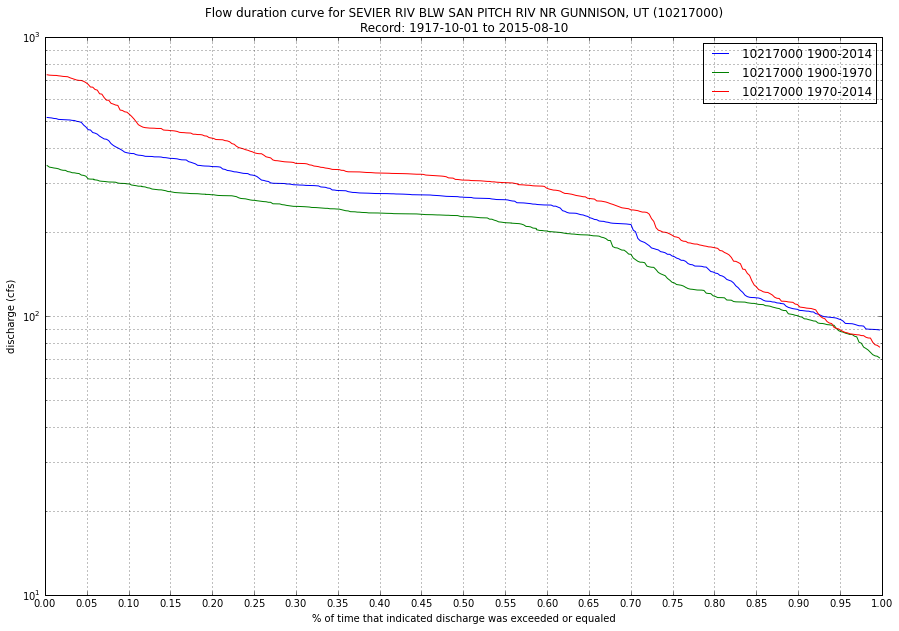

In [28]:
plt.figure()
fdc_simple(USGS_Site_Data,sites[59],1900,2014)
fdc_simple(USGS_Site_Data,sites[59],1900,1970)
fdc_simple(USGS_Site_Data,sites[59],1970,2014)

plt.yscale('log')
plt.grid(which = 'both')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.ylabel('discharge (cfs)')
plt.xticks(np.arange(0.0,1.05,0.05))
plt.title('Flow duration curve for ' + str(USGS_Site_Info['name'][59]) + ' ('+ sites[i] +')'+'\n'+ 
          'Record: ' + str(USGS_Site_Info['start_date'][i])[0:10] + ' to ' + str(USGS_Site_Info['fin_date'][i])[0:10])
plt.legend()

Below are some sad attempts to model the flow duration curves:

curve fit (0.99438131890689874, 0.0028094929764596044, 0.99718670203784243, 0.0, 0.0039178065255456107)
curve fit (0.98609884332391973, 1.4299365512673603, 0.99302533901504852, 0.0, 0.006136593964669923)


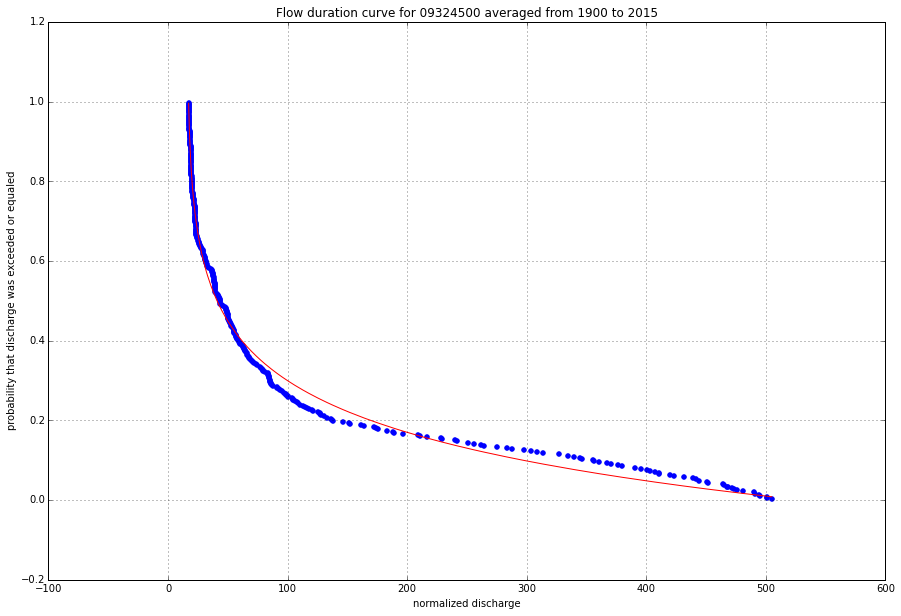

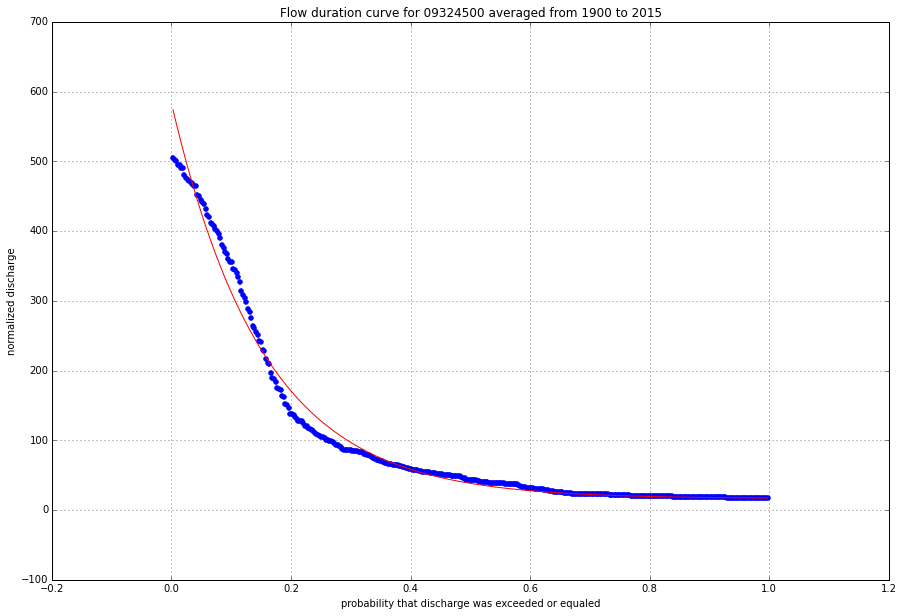

In [29]:
site = sites[32]
df = USGS_Site_Data[[site]]
begyear = 1900
endyear = 2015
data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]
data = data.dropna()

data['doy']=data.index.dayofyear
dailyavg = data[site].groupby(data['doy']).mean()


data = np.sort(dailyavg)

mean = np.mean(data)
std = np.std(data)
f = [(data[i]) for i in range(len(data))]
#f = [(data[i])/mean for i in range(len(data))]
#f = [(data[i]-std)/mean for i in range(len(data))]

ranks = sp.rankdata(f, method='average')
ranks = ranks[::-1]
prob = [(ranks[i]/(len(f)+1)) for i in range(len(f)) ]

x = prob
y = f

plt.figure()
plt.scatter(y,x,label=site,color='blue')
#plt.yscale('log')
#plt.xlim(-.05,1.05)
plt.grid(which = 'both')
plt.ylabel('probability that discharge was exceeded or equaled')
plt.xlabel('normalized discharge')
#plt.xticks(np.arange(0,1.00,0.05))
plt.title('Flow duration curve for ' + site + ' averaged from ' + str(begyear) + ' to ' + str(endyear))

def func(x,a,b,c,d):
    return a*np.log(x*b+c)+d

par, cov = op.curve_fit(func,y,x,p0=[-0.16528617, 1.54535185, -24.70440088, 0.9])
plt.plot(y, [par[0]*np.log(y[i]*par[1]+par[2])+par[3] for i in range(len(y))], color='red')
print 'curve fit', sp.linregress(x,[par[0]*np.log(y[i]*par[1]+par[2])+par[3] for i in range(len(y))])

plt.figure()
plt.scatter(x,y,label=site,color='blue')
#plt.yscale('log')
#plt.xlim(-.05,1.05)
plt.grid(which = 'both')
plt.xlabel('probability that discharge was exceeded or equaled')
plt.ylabel('normalized discharge')
#plt.xticks(np.arange(0,1.00,0.05))
plt.title('Flow duration curve for ' + site + ' averaged from ' + str(begyear) + ' to ' + str(endyear))

def func2(x,a,b,c,d):
    return a*np.exp(x*b+c)+d


parm, covm = op.curve_fit(func2,x,y,p0=[-0.16528617, 0.02, 0.70440088, 0.9])
plt.plot(x, [parm[0]*np.exp(x[i]*parm[1]+parm[2])+parm[3] for i in range(len(x))], color='red')
print 'curve fit', sp.linregress(y,[parm[0]*np.exp(x[i]*parm[1]+parm[2])+parm[3] for i in range(len(x))])

In [30]:
def dic2df(dic,head):
    df = pd.DataFrame(data=dic)
    df = df.transpose()
    df.columns = [str(head)+'_var1',str(head)+'_var2',str(head)+'_var3',str(head)+'_var4',str(head)+'_r2',str(head)+'_err']
    return df

In [31]:
q = {}; m = {}; n = {}; k = {}; j = {}; p = {}

for site in sites:
    q[site] = fdcmatch(USGS_Site_Data,site,1900,2015,1,1)
    m[site] = fdcmatch(USGS_Site_Data,site,1900,1970,1,1)
    n[site] = fdcmatch(USGS_Site_Data,site,1970,2015,1,1)
    k[site] = fdcmatch(USGS_Site_Data,site,1900,2015,1,0)
    j[site] = fdcmatch(USGS_Site_Data,site,1900,1970,1,0)
    p[site] = fdcmatch(USGS_Site_Data,site,1970,2015,1,0)
    
dics = [q,m,n,k,j,p]
heads = ['all','to70','fm70','allin','to70in','fm70in']

USGS_q = dic2df(q,'all')
USGS_m = dic2df(m,'to70')
USGS_parms = pd.merge(USGS_q,USGS_m, left_index=True, right_index=True, how='outer' )

for i in range(2,6,1):
    x = dic2df(dics[i],heads[i])
    USGS_parms = pd.merge(USGS_parms,x, left_index=True, right_index=True, how='outer' )

USGS_parms.to_clipboard()
#USGS_finish_date = USGS_finish_date.drop([0],axis=1)
#USGS_start_fin = pd.merge(USGS_finish_date,USGS_start_date, left_index=True, right_index=True, how='outer' )

The equations from the modeled fdc plots can be used to estimate the discharge for a site based on data from a similar site.  However, the results are mediocre.

(719163.0, 720624.0)

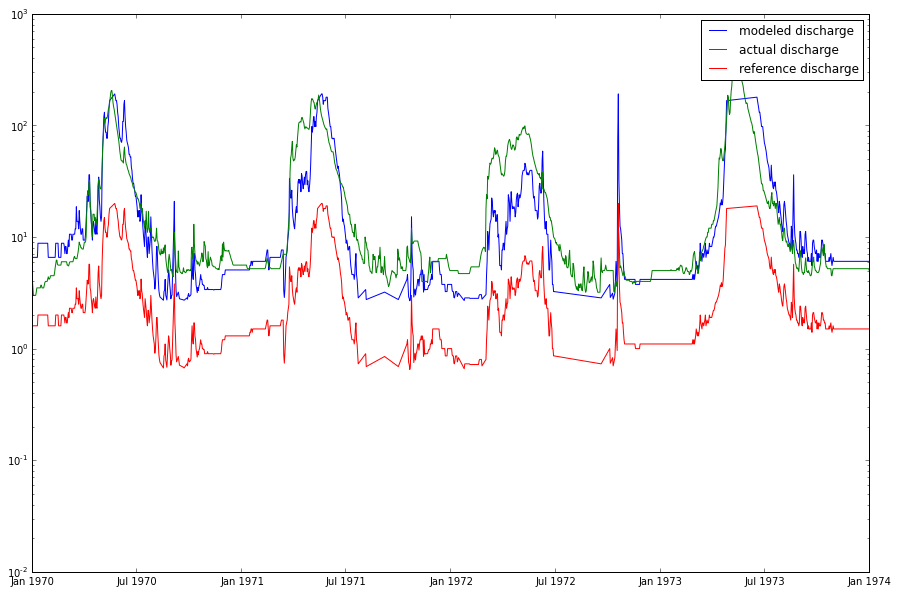

In [164]:
n1 = 12
n2 = 11

USGS_Site_Data[sites[n1]+'p'] = [USGS_parms['all_var1'][n1]*np.log(USGS_Site_Data[sites[n1]][i]*USGS_parms['all_var2'][n1]+\
                                                                   USGS_parms['all_var3'][n1])+USGS_parms['all_var4'][n1] for i in \
range(len(USGS_Site_Data[sites[n1]]))]

USGS_Data = USGS_Site_Data[USGS_Site_Data[sites[n1]+'p']>0]

USGS_Data[sites[n2]+'d'] = [USGS_parms['allin_var1'][n2]*np.exp(USGS_Data[sites[n1]+'p'][i]*USGS_parms['allin_var2'][n2]+\
                                                                   USGS_parms['allin_var3'][n2])+USGS_parms['allin_var4'][n2] for i in \
range(len(USGS_Data[sites[n1]+'p']))]

y1 = USGS_Data[sites[n2]+'d'].values
y2 = USGS_Site_Data[sites[n2]].values

x1 = USGS_Data.index.to_datetime()
x2 = USGS_Site_Data.index.to_datetime()
y3 = USGS_Data[sites[n1]]


plt.figure()
plt.plot(x1,y1, label="modeled discharge")
plt.plot(x2,y2, label="actual discharge")
plt.plot(x1,y3, label="reference discharge")
plt.yscale('log')
plt.legend()
#plt.xlim(USGS_Site_Info['start_date'][n2],USGS_Site_Info['fin_date'][n2])
plt.xlim('1/1/1970','1/1/1974')
#plt.ylim(1,100)


http://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python <br>
http://hydroclimpy.sourceforge.net/installation.html

Run the following script if you want to see a map of your stations.  This assumes that you have the <a href=http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/>Basemap package</a> installed.

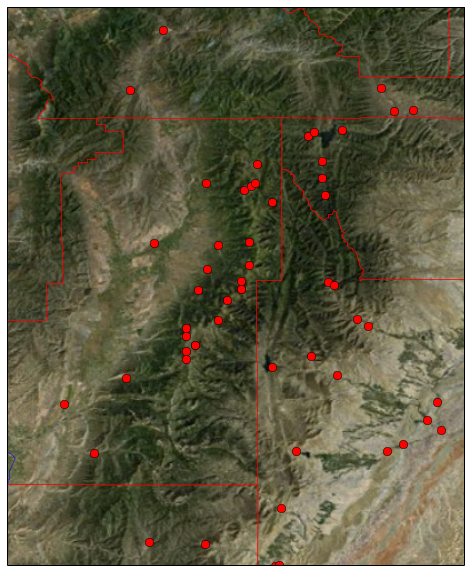

In [24]:
from mpl_toolkits.basemap import Basemap
X = USGS_Site_Info['longitude'].astype(float).values.tolist()
Y = USGS_Site_Info['latitude'].astype(float).values.tolist()

n = 0.05 
m = Basemap(llcrnrlon=min(X)+n,llcrnrlat=min(Y)+n,urcrnrlon=max(X)+n,urcrnrlat=max(Y)+n,
            resolution='h',projection='cyl',lon_0=np.mean(X),lat_0=np.mean(Y))
m.drawrivers(color='blue',linewidth=0.5)
m.drawcounties(color='red',linewidth=0.5)
m.arcgisimage()
#m.etopo(scale=0.5)
lons = X
lats = Y
x,y = m(lons,lats)
m.plot(x,y,'ro', markersize=8)

#m.drawmapscale(lon=-114, lat=43.5, length=100, lon0=-114, lat0=39, barstyle='simple', units='km')

## Analysis in R

In [54]:
col = USGS_Site_Data.columns

In [60]:
import rpy2.robjects as robj
import rpy2.rlike.container as rlc

def pandas_data_frame_to_rpy2_data_frame(pDataframe):
    orderedDict = rlc.OrdDict()

    for columnName in pDataframe:
        columnValues = pDataframe[columnName].values
        filteredValues = [value if pd.notnull(value) else robj.NA_Real 
                          for value in columnValues]

        try:
            orderedDict[columnName] = robj.FloatVector(filteredValues)
        except ValueError:
            orderedDict[columnName] = robj.StrVector(filteredValues)

    rDataFrame = robj.DataFrame(orderedDict)
    rDataFrame.rownames = robj.StrVector(pDataframe.index)

    return rDataFrame

In [61]:
USD = pandas_data_frame_to_rpy2_data_frame(USGS_Site_Data)